In [147]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi,
        hcpcs_code, 
        hcpcs_description, 
        bene_unique_cnt,
        place_of_service
FROM payments 
WHERE provider_type='Orthopedic Surgery'"""
payments = pd.read_sql_query(q, con=con)

In [4]:
payments.shape

(312006, 5)

## construct raw matrix with in and out of facility claims

In [103]:
## out of facility claims
by_npi_O = (payments.query('place_of_service == "O"')[['npi','hcpcs_code','bene_unique_cnt']].
                pivot(index='npi', values = 'bene_unique_cnt', columns='hcpcs_code').
                fillna(value=0))

In [104]:
## in facility claims
by_npi_F = (payments.query('place_of_service == "F"')[['npi','hcpcs_code','bene_unique_cnt']].
                pivot(index='npi', values = 'bene_unique_cnt', columns='hcpcs_code').
                fillna(value=0))

In [105]:
## merge in and out of facility claims
by_npi = (by_npi_O.merge(by_npi_F, how='outer', left_index=True, right_index=True, suffixes=('_O','_F')).
          fillna(value=0))

In [106]:
by_npi.shape

(20652, 1675)

## PCA

In [13]:
X_centered = preprocessing.scale(by_npi.as_matrix(), with_mean=True, with_std=True)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.03332738,  0.02664181,  0.02050587])

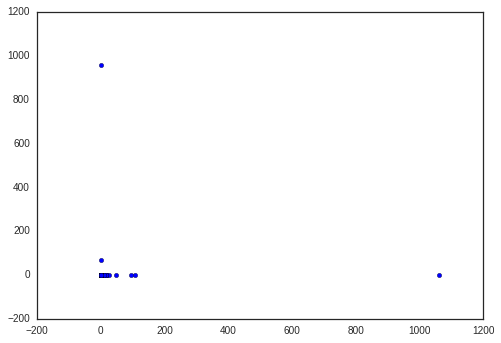

In [17]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])

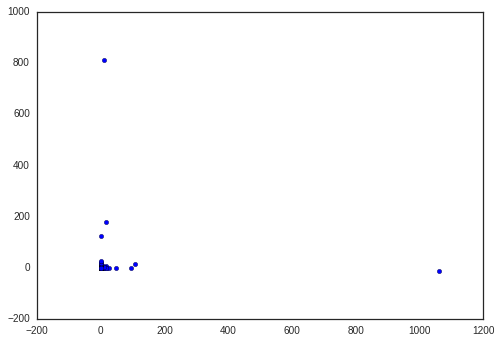

In [15]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])

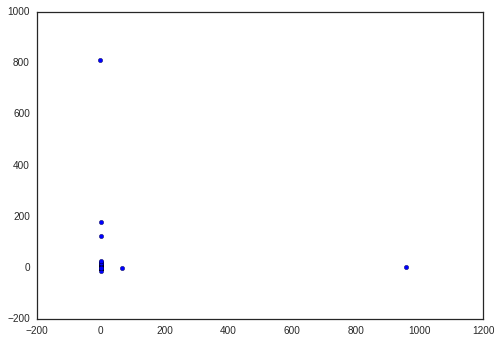

In [16]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])

## Investigate outliers

PC1

In [30]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
hcpcs_code = str(by_npi.columns.values[max_element_pc1])
payments.loc[ payments.hcpcs_code == hcpcs_code]

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
115906,1376541979,83735,Magnesium level,140.0,O
169748,1548254204,83735,Magnesium level,12.0,O


PC 2

In [31]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
hcpcs_code = str(by_npi.columns.values[max_element_pc2])
payments.loc[ payments.hcpcs_code == hcpcs_code]

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
174977,1568408235,87621,Detection test for human papillomavirus (HPV),21.0,O


PC 3

In [32]:
## locate the index of the largest absolute value in principle component 3
max_element_pc3 = np.argmax(np.absolute(svd.components_[2]))
hcpcs_code = str(by_npi.columns.values[max_element_pc3])
payments.loc[ payments.hcpcs_code == hcpcs_code]

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
24458,1073683207,70486,CT scan of face,13.0,O
285563,1912971045,70486,CT scan of face,26.0,O
306698,1982656450,70486,CT scan of face,103.0,O


## What is the distribution of the number of claims per column?

num_claims_per_col = by_npi.astype(bool).sum(axis = 0)

[(0, 20)]

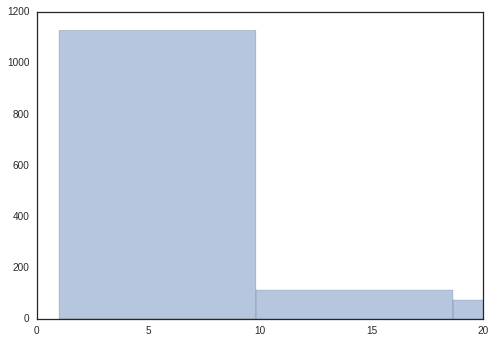

In [53]:
g = sns.distplot(num_claims_per_col, kde = False, bins=2000)
g.set(xlim = (0,20))

In [45]:
sum(num_claims_per_col < 10)

1128

In [47]:
sum(num_claims_per_col < 5)

950

In [48]:
std_per_col = by_npi.std(axis=0)

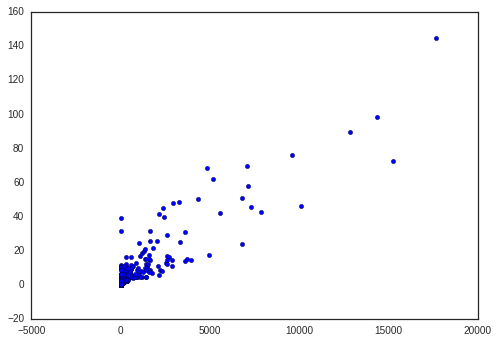

In [49]:
## standard deviation vs number of claims per column?
plt.scatter(x=num_claims_per_col, y=std_per_col)

## Drop columns 
- top 15 most claimed columns
- columns with < 4 claims

In [54]:
counts_per_code = (payments['hcpcs_code'].value_counts().
                   reset_index(name='count').
                   rename(columns={'index': 'hcpcs_code'}))

In [58]:
counts_per_code.head(8)

,hcpcs_code,count
0,99213,20021
1,99203,17086
2,20610,16436
3,99214,14215
4,99212,10931
5,73030,10515
6,73510,8355
7,99204,7891


In [62]:
top_cols_to_drop = list(counts_per_code['hcpcs_code'][:15])
print(len(top_cols_to_drop))
bottom_cols_to_drop = list(counts_per_code.loc[counts_per_code['count'] < 4, 'hcpcs_code'])
print(len(bottom_cols_to_drop))

15
693


In [75]:
cols_to_keep_mask = ((num_claims_per_col < 10000) & (num_claims_per_col > 3))

In [107]:
by_npi = by_npi.loc[:,cols_to_keep_mask]

## Redo PCA

In [108]:
X_centered = preprocessing.scale(by_npi.as_matrix(), with_mean=True, with_std=True)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.02239024,  0.01728048,  0.01331026])

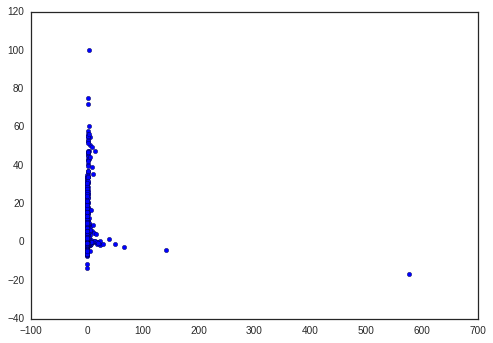

In [109]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])

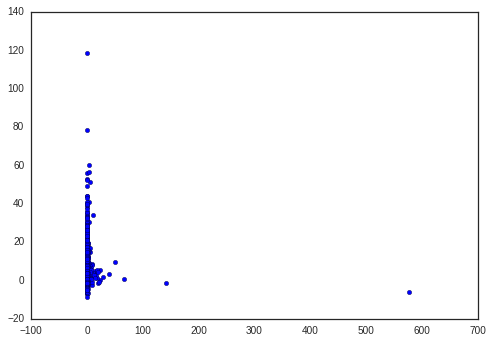

In [110]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])

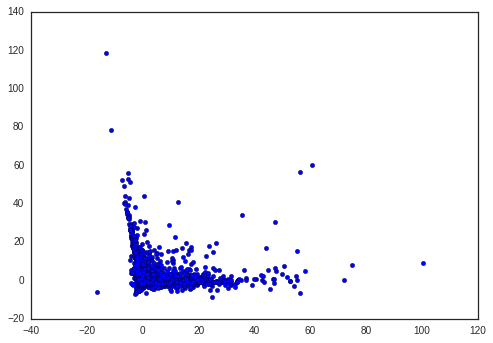

In [111]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])

PC 1

In [112]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
hcpcs_code = str(by_npi.columns.values[max_element_pc1])
payments.loc[ payments.hcpcs_code == hcpcs_code]

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
51800,1164435053,83925,Opiates (drug) measurement,145.0,O
60148,1194711796,83925,Opiates (drug) measurement,177.0,O
65641,1205894524,83925,Opiates (drug) measurement,23.0,O
71671,1225089444,83925,Opiates (drug) measurement,72.0,O
115910,1376541979,83925,Opiates (drug) measurement,1454.0,O
142450,1457375222,83925,Opiates (drug) measurement,396.0,O
224886,1720059207,83925,Opiates (drug) measurement,18.0,O
299044,1952541864,83925,Opiates (drug) measurement,135.0,O


PC 2

In [113]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
hcpcs_code = str(by_npi.columns.values[max_element_pc2])
payments.loc[ payments.hcpcs_code == hcpcs_code].drop_duplicates('hcpcs_code')

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
248,1003059510,22851,Insertion of spinal instrumentation for spinal...,11.0,F


npi 1376541979 is prescribing a ton of opiates!  (in addition to methamphetamine and PCP, not shown here).  Let's drop this npi.

## PCA after dropping Opiates (hcpcs_code 83925)

In [114]:
by_npi.drop(labels='1376541979', axis=0, inplace=True)

In [115]:
by_npi.shape

(20651, 795)

In [116]:
X_centered = preprocessing.scale(by_npi.as_matrix(), with_mean=True, with_std=True)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.01771387,  0.01728018,  0.01331203])

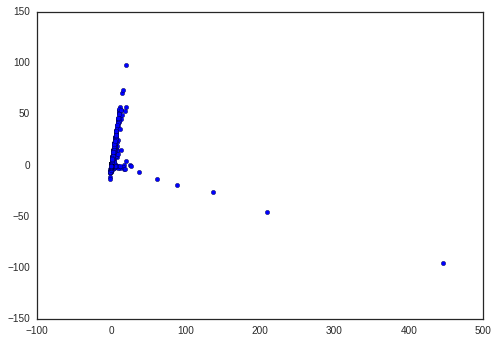

In [117]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])

In [118]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(svd.components_[0]))
hcpcs_code = str(by_npi.columns.values[max_element_pc1])
payments.loc[ payments.hcpcs_code == hcpcs_code]

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
51785,1164435053,80154,Benzodiazepines level,113.0,O
60131,1194711796,80154,Benzodiazepines level,175.0,O
65635,1205894524,80154,Benzodiazepines level,11.0,O
71662,1225089444,80154,Benzodiazepines level,77.0,O
115866,1376541979,80154,Benzodiazepines level,1434.0,O
142428,1457375222,80154,Benzodiazepines level,408.0,O
299038,1952541864,80154,Benzodiazepines level,135.0,O


now npi 1457375222 is dominating PC 1

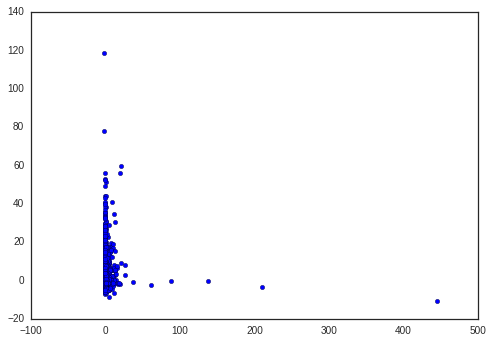

In [119]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])

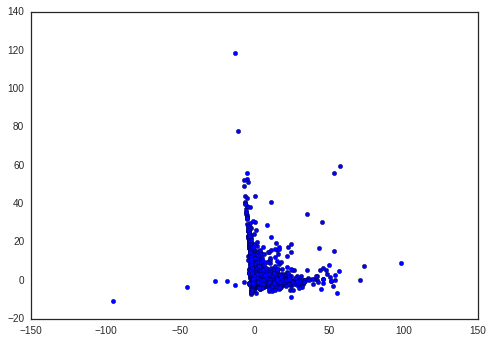

In [120]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])

In [123]:
## locate the index of the largest absolute value in principle component 2
max_element_pc2 = np.argmax(np.absolute(svd.components_[1]))
hcpcs_code = str(by_npi.columns.values[max_element_pc2])
payments.loc[ payments.hcpcs_code == hcpcs_code].drop_duplicates('hcpcs_code')

,npi,hcpcs_code,hcpcs_description,bene_unique_cnt,place_of_service
248,1003059510,22851,Insertion of spinal instrumentation for spinal...,11.0,F


## What is the distribution of number of claims per npi?

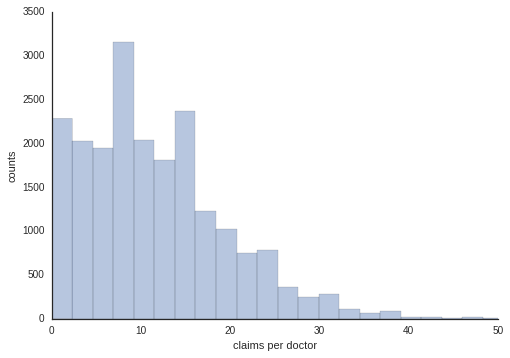

In [127]:
g = sns.distplot((by_npi > 0.0).sum(axis = 1), kde=False, bins=30)
g.set(xlim=(0,50), xlabel='claims per doctor', ylabel='counts')
sns.despine()

In [128]:
## number of npis with < 10 claims
sum(by_npi.astype(bool).sum(axis = 1) < 10)

9409

In [129]:
## number of npis with < 5 claims
sum(by_npi.astype(bool).sum(axis = 1) < 5)

4307

In [130]:
## number of npis with < 8 claims
sum(by_npi.astype(bool).sum(axis = 1) < 8)

7246

In [131]:
## only keep npis >= 10 claims
by_npi = by_npi[by_npi.astype(bool).sum(axis = 1) > 9]

In [132]:
by_npi.shape

(11242, 795)

## t SNE on smaller data set

In [133]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11242
[t-SNE] Computed conditional probabilities for sample 2000 / 11242
[t-SNE] Computed conditional probabilities for sample 3000 / 11242
[t-SNE] Computed conditional probabilities for sample 4000 / 11242
[t-SNE] Computed conditional probabilities for sample 5000 / 11242
[t-SNE] Computed conditional probabilities for sample 6000 / 11242
[t-SNE] Computed conditional probabilities for sample 7000 / 11242
[t-SNE] Computed conditional probabilities for sample 8000 / 11242
[t-SNE] Computed conditional probabilities for sample 9000 / 11242
[t-SNE] Computed conditional probabilities for sample 10000 / 11242
[t-SNE] Computed conditional probabilities for sample 11000 / 11242
[t-SNE] Computed conditional probabilities for sample 11242 / 11242
[t-SNE] Mean sigma: 43.535031
[t-SNE] Iteration 25: error = 1.0792996, gradient norm = 0.0004524
[t-SNE] Itera

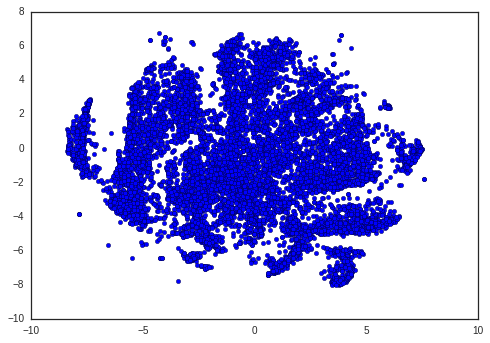

In [134]:
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [146]:
## Write out embedded coordinates
pd.DataFrame(X_embedded, index=by_npi.index, columns=['x_tsne','y_tsne']).to_csv("17_X_embedded.csv", index=True)

## mini Batch kmeans clustering

In [187]:
X = preprocessing.scale(by_npi.as_matrix(), with_mean=True, with_std=False)

In [188]:
batch_size = 100

mbk = MiniBatchKMeans(init='k-means++', n_clusters=10, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

/home/cathy/miniconda3/envs/medicare_provider_util_payment/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1279: DeprecationWarning: This function is deprecated. Please call randint(0, 11241 + 1) instead
  0, n_samples - 1, init_size)
/home/cathy/miniconda3/envs/medicare_provider_util_payment/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 11241 + 1) instead
  0, n_samples - 1, init_size)
/home/cathy/miniconda3/envs/medicare_provider_util_payment/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 11241 + 1) instead
  0, n_samples - 1, init_size)
/home/cathy/miniconda3/envs/medicare_provider_util_payment/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 11241 + 1) instead
  0, n_samples - 1, init_size)
/home/cathy/miniconda3/envs/med

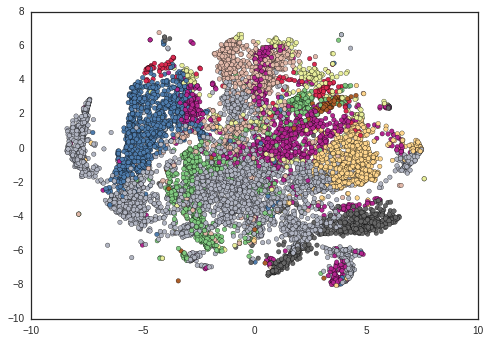

In [189]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], cmap=cm.get_cmap('Accent',10), c=mbk.labels_)

## Write by_npi out to file
- dropped top 15 cols
- dropped cols with < 4 claims
- dropped npi 1376541979
- dropped npi's with < 10 claims

In [191]:
by_npi.to_csv("17_by_npi_reduced_ortho.csv", index=True)